## TP 3.2 : Gain et impact de marché

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

Nous allons repartir du code du TP3.1 pour la simulation du jeu de la minorité à nombre de spéculateurs variable.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
import pandas as pd

In [40]:
# Dans un premier temps, crééons une fonction permettant d'initialiser les stratégies.

def initialize(Ns, P, Np):
    """La fonction initialize prend trois arguments :
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : les autres agents
    On retourne la matrice strategies, la matrice performance, ainsi que le vecteur Omega et le nombre mu."""

    # On initialise les agents avec des stratégies aléatoires entre -1 et 1
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    # On initialise les performances à 0
    performance = np.zeros(Ns)

    # On initialise omega et mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # On veut générer un nombre entre 0 et P-1 inclus
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

In [41]:
# On va créer une version améliorée de la fonction simulation, en compilant avec numba pour diminuer la complexité temporelle des algorithmes.
@jit(nopython=True)
def simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon):
    A_history = np.zeros(T)
    mu_history = np.zeros(T, dtype=np.int32)

    for t in range(T):
        a_mu_t = strategies[:, mu]
        n_i = (performance >= 0).astype(np.int32)
        A_t = Omega[mu] + np.sum(n_i * a_mu_t)
        A_history[t] = A_t
        performance += -a_mu_t * A_t - epsilon
        mu = np.random.randint(0, P)
        mu_history[t] = mu

    return A_history, mu_history, performance

In [42]:
# Une fois qu'on a l'initialisation et la simulation, nous pouvons créer une fonction permettant d'afficher le résultat graphique de la simulation.

def plot_simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction plot_simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On affiche le graphique de A(t) au cours du temps."""

    # On récupère l'historique des actions grâce à la fonction simulation.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history, _, _ = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)
    plt.figure(figsize=(10, 5))
    plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    plt.xlabel('Temps')
    plt.ylabel('A(t)')
    plt.title('Simulation de A(t) au cours du temps')
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 100 # L'horizon temporel
Ns = 10 # Le nombre de spéculateurs
epsilon = 0.01 # La performance minimale pour continuer de participer au jeu

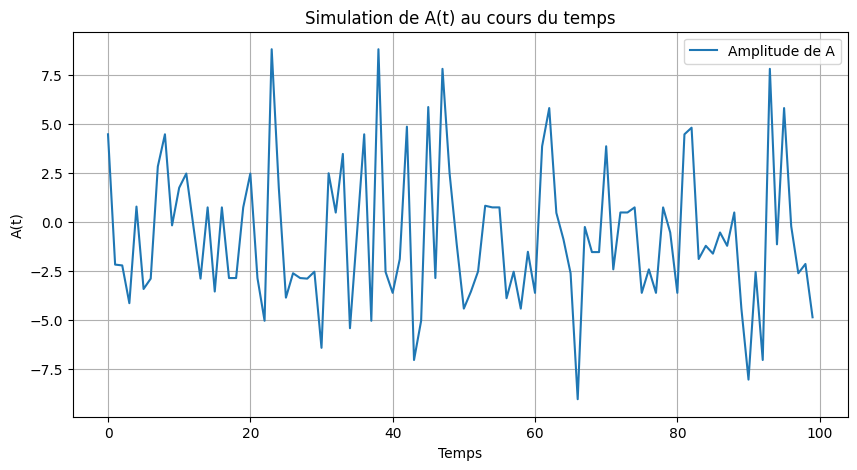

In [44]:
# Déjà, nous allons afficher la simulation pour les paramètres précédents définis.
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

### 1. Gain de catégories d'investisseurs

1. calculer le gain moyen des producteurs et des spéculateurs en variant $N_s$ tout les autres paramètres étant fixés. Comment ces gains évoluent-ils en fonction de $N_s$ ?

In [45]:
def calculate_gains(Ns_values, P, Np, M, T, epsilon, num_iterations):
    producer_gains = []
    speculator_gains = []

    for Ns in Ns_values:
        all_producer_gains = []
        all_speculator_gains = []

        for _ in range(num_iterations):
            strategies, performance, Omega, mu = initialize(Ns, P, Np)
            A_history, _, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)

            producer_gain = np.mean(Omega)
            all_producer_gains.append(producer_gain)

            speculator_gain = np.mean(performance)
            all_speculator_gains.append(speculator_gain)

        producer_gains.append(np.mean(all_producer_gains))
        speculator_gains.append(np.mean(all_speculator_gains))

    return producer_gains, speculator_gains

In [46]:
def plot_gains(Ns_values, producer_gains, speculator_gains):
    plt.figure(figsize=(10, 5))
    plt.plot(Ns_values, producer_gains, label='Gain Moyen des Producteurs')
    plt.plot(Ns_values, speculator_gains, label='Gain Moyen des Spéculateurs')
    plt.xlabel('Nombre de Spéculateurs (Ns)')
    plt.ylabel('Gain Moyen')
    plt.title('Évolution des Gains en Fonction de Ns')
    plt.legend()
    plt.grid()
    plt.show()

In [47]:
Ns_values = np.linspace(10, 1000, 15).astype(int)
num_iterations = 1000
producer_gains, speculator_gains = calculate_gains(Ns_values, P, Np, M, T, epsilon, num_iterations)

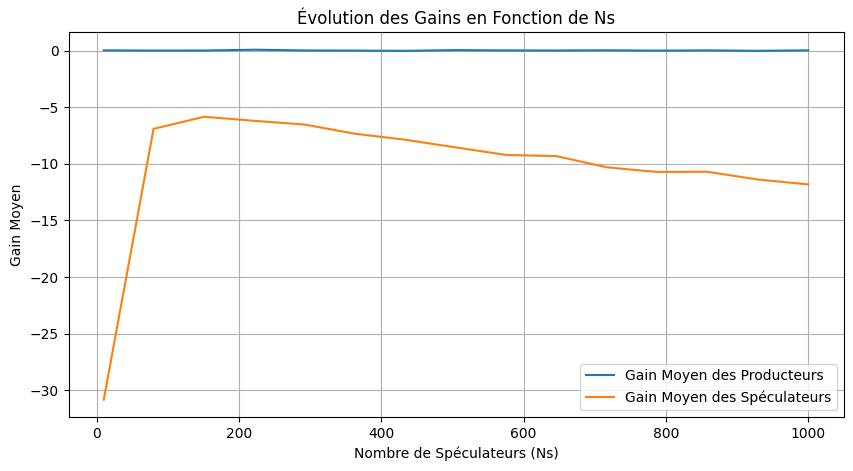

In [48]:
plot_gains(Ns_values, producer_gains, speculator_gains)

Commentaires : La courbe illustrant l'évolution des gains moyens des producteurs et des spéculateurs en fonction du nombre de spéculateurs $N_s$ montre que le gain moyen des producteurs reste relativement stable autour de zéro, reflétant leur contribution fixe $\Omega_\mu$, qui ne varie pas avec le nombre de spéculateurs. En revanche, le gain moyen des spéculateurs indique des pertes importantes lorsque $N_s$ est faible, suivie d'une stabilisation négative à mesure que $N_s$ augmente. Cette tendance suggère que les spéculateurs subissent des pertes significatives dans un système où les interactions sont déséquilibrées, sans parvenir à un gain positif, probablement en raison de la compétition accrue et de la performance minimale requise. On observe une tendance à la décroissance quand $N_s$ augmente trop, montrant que l'augmentation du nombre de spéculateurs accroît la compétition, ce qui rend plus difficile l'obtention de gains positifs dans un environnement où les stratégies doivent constamment s'adapter.

2. Prenons des paramètres pour lesquels le gain des spéculateurs est négatif et augmenter $N_p$ en laissant les autres paramètres fixes. Comment ces gains évoluent-ils en fonction de $N_p$ ?

Nous allons considérer les paramètres que nous avons utilisé dans la question précédente puisqu'on a obtenu un gain négatif pour les spéculateurs.

In [49]:
def calculate_gains_for_Np(Np_values, Ns, P, M, T, epsilon, num_iterations):
    producer_gains = []
    speculator_gains = []

    for Np in Np_values:
        all_speculator_gains = []
        all_producer_gains = []

        for _ in range(num_iterations):
            strategies, performance, Omega, mu = initialize(Ns, P, Np)
            A_history, _, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)

            producer_gain = np.mean(Omega)
            all_producer_gains.append(producer_gain)

            speculator_gain = np.mean(performance)
            all_speculator_gains.append(speculator_gain)

        producer_gains.append(np.mean(all_producer_gains))
        speculator_gains.append(np.mean(all_speculator_gains))

    return producer_gains, speculator_gains

In [50]:
def plot_gains_for_Np(Np_values, produce_gains, speculator_gains):
    plt.figure(figsize=(10, 5))
    plt.plot(Np_values, producer_gains, label='Gain Moyen des Producteurs', color='blue')
    plt.plot(Np_values, speculator_gains, label='Gain Moyen des Spéculateurs', color='orange')
    plt.xlabel('Nombre de Producteurs (Np)')
    plt.ylabel('Gain Moyen')
    plt.title('Évolution des Gains en Fonction de Np')
    plt.legend()
    plt.grid()
    plt.show()

In [51]:
Ns = 500
Np_values = np.linspace(10, 1000, 15).astype(int)

producer_gains, speculator_gains = calculate_gains_for_Np(Np_values, Ns, P, M, T, epsilon, num_iterations)

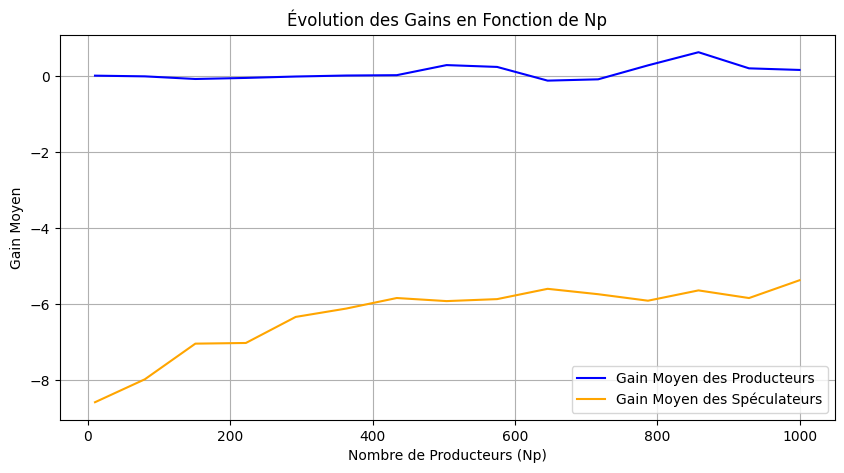

In [52]:
plot_gains_for_Np(Np_values, producer_gains, speculator_gains)

Commentaires : On se rend compte que l'augmentation du nombre de spéculateurs n'influence pas la moyenne des gains pour les producteurs, mais leur variance qui vaut $N_p$ ! Ainsi, cela explique l'augmentation des fluctuations (autour de 0 toujours, la contribution des producteurs suivant une loi normale centrée en 0) du gain moyen des producteurs. En revanche, les gains des spéculateurs montrent une légère augmentation à mesure que $N_p$ augmente. Cela pourrait être dû au fait qu'un plus grand nombre de producteurs introduit une certaine stabilité dans le système, permettant aux spéculateurs de mieux ajuster leurs stratégies et d'obtenir des gains légèrement meilleurs. Cependant, ces gains restent toujours négatifs et semblent tendre vers une valeur limite.

3. Comment décrire la relation entre ces deux catégories d’investisseurs en empruntant le langage de l’écologie de populations ?

En empruntant le langage de l'écologie des populations, nous pouvons décrire la relation entre les producteurs et les spéculateurs dans le jeu de la minorité comme une dynamique prédateur-proie, où les spéculateurs agissent comme des prédateurs et les producteurs comme des proies.

Les producteurs, avec leur contribution fixe et prévisible, peuvent être vus comme les proies de cet écosystème. Leur comportement stable et constant représente une ressource exploitable par les spéculateurs.
La stabilité de leur gain moyen, même lorsque leur nombre augmente, reflète une capacité de l'écosystème à maintenir une certaine constance dans la disponibilité des ressources, indépendamment de la densité des proies.

Les spéculateurs, en tant que prédateurs, cherchent à maximiser leurs gains en exploitant les ressources fournies par les producteurs. Leur comportement compétitif et adaptatif est similaire à celui des prédateurs qui ajustent leurs stratégies de chasse en fonction de la disponibilité des proies. Plus le nombre de producteurs augmente et plus le gain des spéculateurs augmente : on a un scénario d'augmentation de la population des proies qui stabilise l'écosystème, permettant aux prédateurs de mieux s'adapter et d'améliorer leur survie.

Lorsque le nombre de spéculateurs augmente, le gain des spéculateurs, qui atteignait jusqu'alors un maximum, diminue puisque les ressources à se partager n'augmentent pas mais que la part individuelle pour chaque prédateur se fait de plus en plus rare... Lorsque le nombre de spéculateur est faible, leur gain est d'autant plus faible puisque la compétition entre les spéculateurs reste intense, et leur manque d'expérience ou d'adaptation les empêche de maximiser efficacement leurs gains dans cet environnement riche en opportunités.

### 2. Gain réel, gain espéré

Choisissons des paramètres pour lesquels les fluctuations de $A(t)$ ne présentent pas de grandes fluctuations au cours du temps.

Les paramètres initiaux devraient convenir. Vérifions cela :

In [53]:
# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 100 # L'horizon temporel
Ns = 10 # Le nombre de spéculateurs
epsilon = 0.01 # La performance minimale pour continuer de participer au jeu

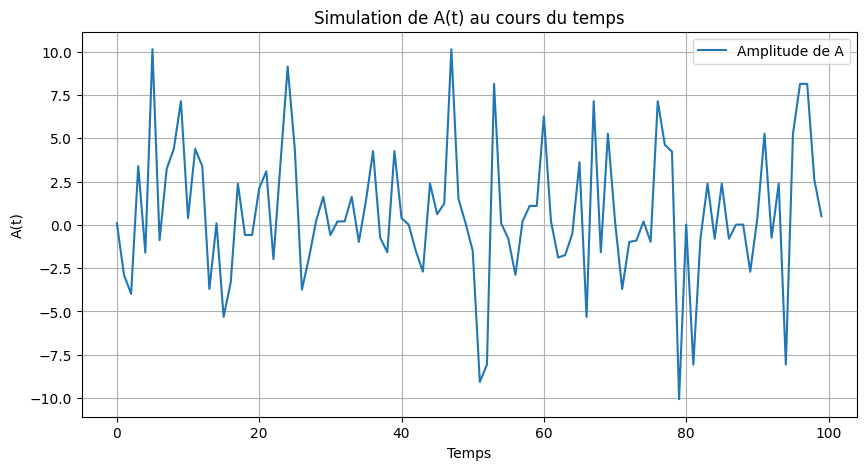

In [54]:
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

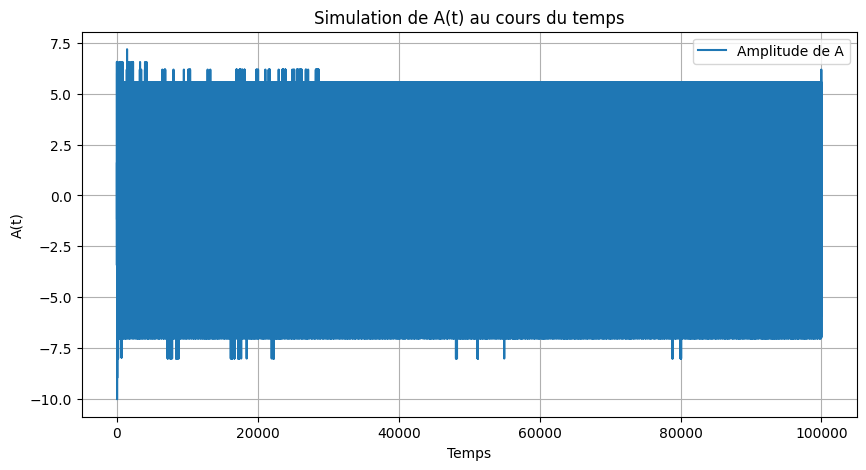

In [55]:
T = 100000
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

Donc les fluctuations sont contenues au cours du temps.

1. Calculer les moyennes conditionnelles $\mathbb{E}[A|\mu]$ pour tous les $\mu$ pour une réalisation de ce jeu.

In [56]:
def conditional_means(Ns, P, Np, M, T, epsilon):
    strategies, performance, Omega, mu = initialize(Ns, P, Np)
    A_history, mu_history, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)

    conditional_mean_A = np.zeros(P)

    for mu in range(P):
        indices = np.where(mu_history == mu)[0]
        if len(indices) > 0:
            conditional_mean_A[mu] = np.mean(A_history[indices])

    return conditional_mean_A

In [57]:
conditional_mean_A = conditional_means(Ns, P, Np, M, T, epsilon)

print("Moyennes conditionnelles E[A|μ]:")
print(pd.DataFrame(conditional_mean_A, index = np.arange(1,17)))

Moyennes conditionnelles E[A|μ]:
           0
1   0.550291
2   0.469126
3   0.499241
4   0.512535
5   0.532295
6   0.538904
7   0.473526
8   0.523775
9   0.526983
10  0.434941
11  0.613972
12  0.485974
13  0.514163
14  0.467817
15  0.565602
16  0.450961


2. Créons maintenant un agent qui a tout compris du jeu et qui a la possibilité de jouer exactement $a_{best}(\mu) = −sign (\mathbb{E}[A|\mu])$. Son espérance de gain moyen naïve est $\frac{1}{P} \sum_{\mu} |\mathbb{E}[A|\mu]|$.

In [58]:
def optimal_agent_strategy(conditional_mean_A):
    optimal_strategy = -np.sign(conditional_mean_A)
    return optimal_strategy

In [59]:
def optimal_agent_expected_gain(conditional_mean_A):
    expected_gain = np.mean(np.abs(conditional_mean_A))
    return expected_gain

In [60]:
conditional_mean_A_optimal = conditional_means(Ns, P, Np, M, T, epsilon)
optimal_strategy = optimal_agent_strategy(conditional_mean_A_optimal)
expected_gain = optimal_agent_expected_gain(conditional_mean_A_optimal)

print("Stratégie optimale de l'agent:", optimal_strategy)
print("Espérance de gain moyen naïve:", expected_gain)

Stratégie optimale de l'agent: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Espérance de gain moyen naïve: 0.3850646118020672


3. Ajoutons cet agent au modèle en question et continuons les simulations du modèle en question. Calculons maintenant le gain moyen de l’agent best, comparons le avec son gain espéré, et commentons.

In [66]:
# On va ajouter l'agent optimal à la simulation de notre stratégie.
@jit(nopython=True)
def simulation_optimal_agent_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon, optimal_strategy):
    A_history = np.zeros(T)
    mu_history = np.zeros(T, dtype=np.int32)
    optimal_agent_performance = 0

    for t in range(T):
        a_mu_t = strategies[:, mu]
        n_i = (performance >= 0).astype(np.int32)

        optimal_action = optimal_strategy[mu]
        A_t = Omega[mu] + np.sum(n_i * a_mu_t) + optimal_action

        optimal_agent_performance += -optimal_action * A_t

        A_history[t] = A_t
        performance += -a_mu_t * A_t - epsilon
        mu = np.random.randint(0, P)
        mu_history[t] = mu

        optimal_agent_average_gain = optimal_agent_performance / T

    return A_history, mu_history, performance, optimal_agent_average_gain

In [70]:
conditional_mean_A = conditional_means(Ns, P, Np, M, T, epsilon)
optimal_strategy = optimal_agent_strategy(conditional_mean_A)
expected_gain = optimal_agent_expected_gain(conditional_mean_A)

strategies, performance, Omega, mu = initialize(Ns, P, Np)
A_history, mu_history, performance, optimal_agent_average_gain = simulation_optimal_agent_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon, optimal_strategy)

print("Stratégie optimale de l'agent:", optimal_strategy)
print("Espérance de gain moyen naïve:", expected_gain)
print("Gain moyen réel de l'agent optimal:", optimal_agent_average_gain)

Stratégie optimale de l'agent: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Espérance de gain moyen naïve: 1.0958332534127244
Gain moyen réel de l'agent optimal: -1.3977785851401312


On va essayer de visualiser les résultats sur plusieurs itérations.

In [73]:
def run_multiple_iterations(Ns, P, Np, M, T, epsilon, num_iterations):
    expected_gains = []
    actual_gains = []

    for _ in range(num_iterations):
        conditional_mean_A = conditional_means(Ns, P, Np, M, T, epsilon)
        optimal_strategy = optimal_agent_strategy(conditional_mean_A)
        expected_gain = optimal_agent_expected_gain(conditional_mean_A)

        strategies, performance, Omega, mu = initialize(Ns, P, Np)
        A_history, mu_history, performance, optimal_agent_average_gain = simulation_optimal_agent_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon, optimal_strategy)

        expected_gains.append(expected_gain)
        actual_gains.append(optimal_agent_average_gain)

    return expected_gains, actual_gains

In [99]:
def plot_gains_comparison(expected_gains, actual_gains, num_iterations):
    plt.figure(figsize=(10, 5))
    plt.scatter([i for i in range(len(expected_gains))], expected_gains, label='Gain Naïf espéré', color='blue')
    plt.hlines(np.mean(expected_gains), [i for i in range(len(expected_gains))][0], [i for i in range(len(expected_gains))][-1],  label='Moyenne du Gain Naïf espéré', color='black', linestyle='--')
    plt.scatter([i for i in range(len(actual_gains))], actual_gains, label='Gain Moyen Réel de l\'Agent Optimal', color='orange')
    plt.hlines(np.mean(actual_gains), [i for i in range(len(expected_gains))][0], [i for i in range(len(expected_gains))][-1], label='Moyenne du Gain Moyen Réel', color='black', linestyle='-')
    plt.xlabel('Itération')
    plt.ylabel('Gain Moyen')
    plt.title(f'Comparaison des Gains Moyens naïfs et réels de l\'Agent optimal sur {num_iterations} Itérations')
    plt.legend()
    plt.grid()
    plt.show()

In [101]:
expected_gains, actual_gains = run_multiple_iterations(Ns, P, Np, M, T, epsilon, num_iterations)

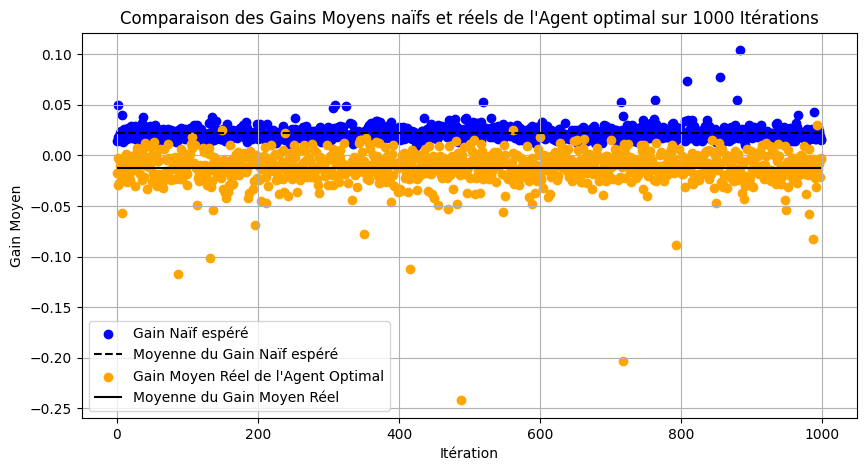

In [102]:
plot_gains_comparison(expected_gains, actual_gains, num_iterations)

Commentaires : Le graphique ci-dessus compare l'espérance de gain moyen naïve et le gain moyen réel de l'agent optimal sur 1000 itérations, illustrant une dispersion notable des résultats. Les points bleus, qui représentent l'espérance de gain moyen naïve, montrent une distribution autour de valeurs positives, ce qui était attendu de part la définition de la métrique, calculée à partir des valeurs absolues des moyennes conditionnelles. En revanche, les points orange, symbolisant le gain moyen réel de l'agent optimal, se concentrent souvent autour de valeurs négatives, suggérant que l'agent optimal ne parvient pas toujours à maximiser ses gains de manière efficace. Cette divergence pourrait être expliquée par la variabilité inhérente du jeu et aux effets aléatoires inévitables dans les simulations. De plus, la stratégie optimale, bien que conçue pour exploiter les informations disponibles, pourrait ne pas être parfaitement adaptée à toutes les situations : peut être que des modifications des paramètres sont à envisager pour voir apparaître une stratégie avec une meilleure performance.

Mais un faible nombre de spéculateurs peut la cause de cet écart : la compétition entre eux est moins intense, ce qui peut entraîner des gains plus faibles et plus dispersés et donner plus d'influence à la variabilité inhérente du jeu. De plus, les spéculateurs peuvent ne pas avoir suffisamment d'opportunités pour ajuster leurs stratégies de manière optimale.

Essayons d'augmenter le nombre de spéculateurs, tout en gardant des fluctuations faibles au cours du temps.

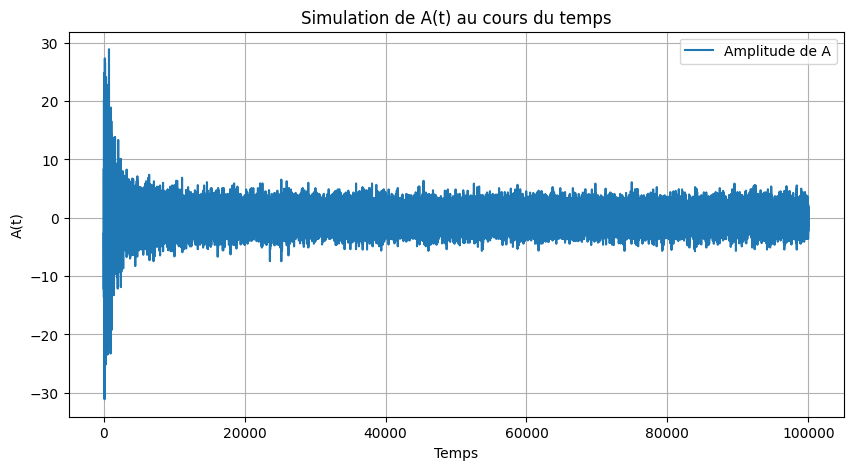

In [84]:
Ns = 100
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

In [103]:
expected_gains, actual_gains = run_multiple_iterations(Ns, P, Np, M, T, epsilon, num_iterations)

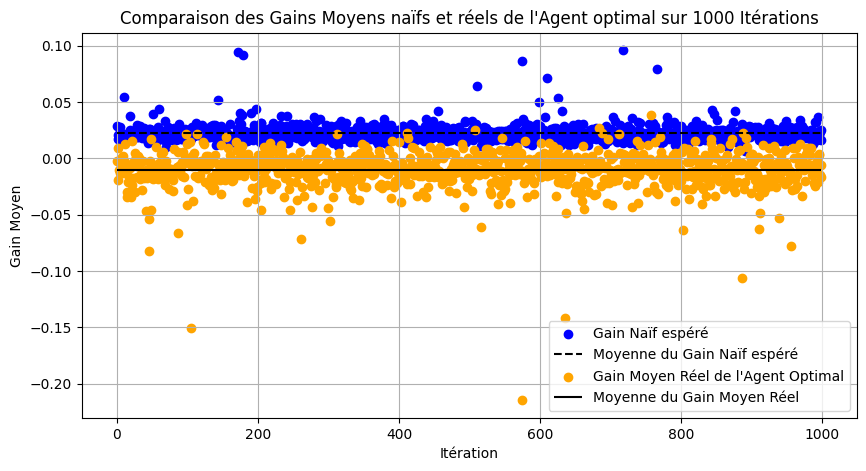

In [104]:
plot_gains_comparison(expected_gains, actual_gains, num_iterations)

Commentaires : L'augmentation du nombre de spéculateurs a réduit la dispersion des valeurs et a resseré l'écart entre gain moyen réel et gain espéré. Les spéculateurs se sont donc mieux adaptés au jeu et ont optimisé leur stratégie en se rapprochant de la stratégie optimale.

Nous pourrions tracer l'évolution des écarts quadratiques moyens des gains réels et naïfs en fonction du nombre de spéculateurs, mais il faudrait pour cela nous arrêter autour de 100 spéculateurs afin d'être certain que les amplitudes de $A(t)$ sont contrôlées au cours du temps.

In [105]:
def calculate_mse(Ns, P, Np, M, T, epsilon, num_iterations):
    mse_values = []

    for _ in range(num_iterations):
        conditional_mean_A = conditional_means(Ns, P, Np, M, T, epsilon)
        optimal_strategy = optimal_agent_strategy(conditional_mean_A)
        expected_gain = optimal_agent_expected_gain(conditional_mean_A)

        strategies, performance, Omega, mu = initialize(Ns, P, Np)
        A_history, mu_history, performance, optimal_agent_average_gain = simulation_optimal_agent_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon, optimal_strategy)

        mse = (expected_gain - optimal_agent_average_gain) ** 2
        mse_values.append(mse)

    return np.mean(mse_values)

In [110]:
def plot_mse(Ns_values, mse_values):
    plt.figure(figsize=(10, 5))
    plt.plot(Ns_values, mse_values, label='MSE entre Gain Réel et Gain Espéré', color='red', marker='o')
    plt.xlabel('Nombre de Spéculateurs (Ns)')
    plt.ylabel('Écart Quadratique Moyen (MSE)')
    plt.title('Évolution du MSE en Fonction de Ns')
    plt.legend()
    plt.grid()
    plt.show()

In [108]:
Ns_values = np.linspace(10, 100, 15).astype(int)
mse_values = [calculate_mse(Ns, P, Np, M, T, epsilon, num_iterations) for Ns in Ns_values]

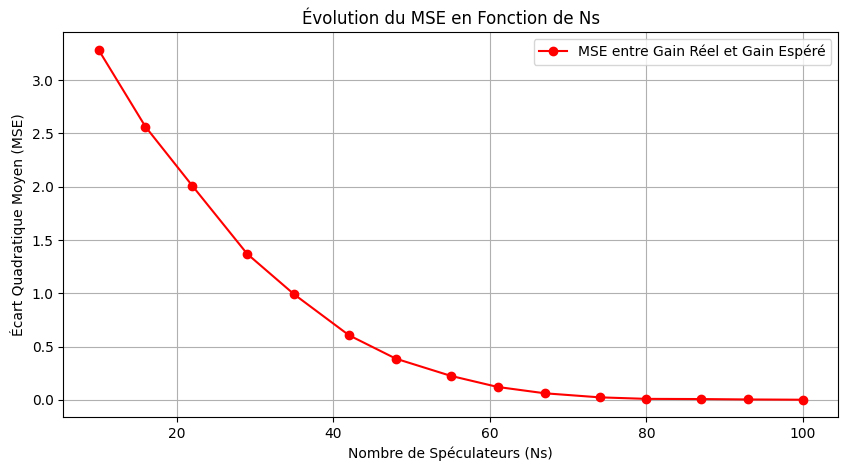

In [111]:
plot_mse(Ns_values, mse_values)

Commentaires : On se rend ainsi compte que le nombre de spéculateurs joue sur la convergence du gain réel vers le gain espéré. Pour 100 spéculateurs, les deux notions sont très proches, ce qui est confirmé par le scatter plot affiché précédemment.